#  Catalog Halo Mass Function

---
**License**

 Catalog Halo Mass Function

 Sat Jul 5 15:00:00 2025\
 Copyright  2025\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Henique Cardoso Naves Lettieri <henrique.cnl23@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---
 catalogs_matching\
 Copyright (C) 2025 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Henrique Cardoso Naves Lettieri <henrique.cnl23@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Libraries & Configs

In [1]:
from astropy.io import fits
import sys
import pandas as pd
from astropy.table import unique, Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
import shutil
from numcosmo_py import Ncm, Nc, sky_match
from numcosmo_py.external.pyssc import pyssc as PySSC
from numcosmo_py.plotting.tools import set_rc_params_article
from numcosmo_py.helper import npa_to_seq
set_rc_params_article(ncol=1,use_tex = bool(shutil.which("latex")))
import timeit
Ncm.cfg_init()

from getdist.mcsamples import  MCSamples
from getdist import plots

import getdist
sys.path.insert(0, "/global/homes/l/lettieri/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/l/lettieri/gcr-catalogs")
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")
from GCR import GCRQuery



%matplotlib inline

## Data

In [3]:
zmin = 0.0
zmax = 1.1
logMmin = 13.0
logMmax = 16.0

cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

# Taking some important information about the fiducial cosmological model and survey region
dc2_cosmology = cosmodc2.cosmology
sky_area = cosmodc2.sky_area



sky_area =  439.790 

print("CosmoDC2 info:")
print(f"Version: {cosmodc2.get_catalog_info('version')}")
print(f"Sky area: {cosmodc2.get_catalog_info('sky_area')}")
print(f"Cosmology: {cosmodc2.get_catalog_info('cosmology')}")

data_dc2 = cosmodc2.get_quantities(
    ["halo_id" , "redshift_true", "halo_mass", "ra_true", "dec_true"],
    filters=[
        f"redshift_true > {zmin}",
        f"redshift_true < {zmax}",
        f"halo_mass > {10**logMmin}",
        f"halo_mass < {10**logMmax}",
        f"is_central == {True}", 
    ],
)



data_dc2 = Table(data_dc2)
#hdu = fits.BinTableHDU(data=data_dc2)
#hdu.writeto('cosmodc2.fits')
print(data_dc2.columns)
data_dc2['halo_mass'] = np.log(data_dc2['halo_mass'])
zmin = data_dc2['redshift_true'].min()
zmax = data_dc2['redshift_true'].max()

data_dc2 = Table(data_dc2)
data_dc2.write('cosmodc2_hmf.fits', format='fits', overwrite=True)

CosmoDC2 info:
Version: 1.1.4
Sky area: 439.78987
Cosmology: {'H0': 71.0, 'Om0': 0.2648, 'Ob0': 0.0448, 'sigma8': 0.8, 'n_s': 0.963}
<TableColumns names=('ra_true','halo_mass','redshift_true','halo_id','dec_true')>


# Cosmological Model

In [4]:
#cosmological model
cosmo = Nc.HICosmoDEXcdm()
cosmo.param_set_by_name("Omegax", dc2_cosmology.Ode0)
cosmo.param_set_by_name("H0", dc2_cosmology.H0.value)
cosmo.param_set_by_name("Omegab", dc2_cosmology.Ob0)
cosmo.param_set_by_name("Omegac", dc2_cosmology.Odm0)  # 0.2603
cosmo.param_set_by_name("w", -1.0)  # -1.0

prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.0)
prim.props.n_SA =  0.963 
reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

#matter power spectrum
tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
psf.prepare(cosmo)
#Calculating cosmodc2 sigma_8
print(cosmo.sigma8(psf))
old_amplitude = np.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = np.log(
    (0.8/ cosmo.sigma8(psf)) ** 2 * old_amplitude
)
print(0.8, cosmo.sigma8(psf) , prim.props.ln10e10ASA)



dist = Nc.Distance.new(2.0)
dist.prepare(cosmo)

0.7764593327536546
0.8 0.8 3.0597349179015914


# Cluster Mass and Spectroscopic model 

In [6]:
#mass proxy
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10**logMmin), lnM_max=np.log(10**logMmax))
#photo-z
cluster_z = Nc.ClusterRedshiftNodist (z_min = zmin, z_max = zmax)

# Cluster abundance model

## HMF as a function of mass

206232.14675290554
204625.0165825557


/tmp/ipykernel_1963943/678385973.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  diff = [(abundance[j] - counts_lnM[j])/counts_lnM[j] for j in range(len(lnM)-1)]


233547.99493034036


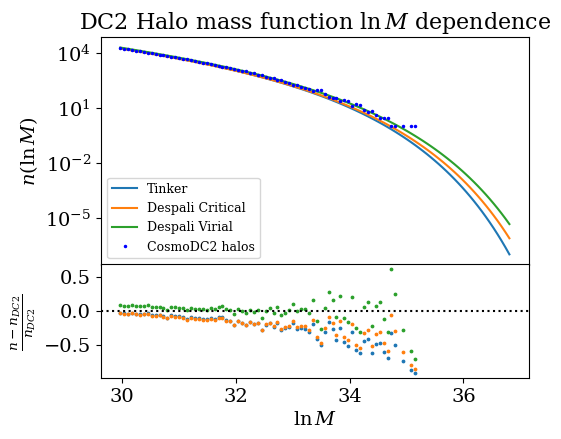

In [8]:
mulfs = [Nc.MultiplicityFuncTinker.new() , Nc.MultiplicityFuncDespali.new(), Nc.MultiplicityFuncDespali.new()]
mulf_label = ["Tinker", "Despali Critical" , "Despali Virial"]
nbins=100

lnM = np.linspace(np.log(10**logMmin), np.log(10**logMmax) , nbins +1)
lnM_bin = [(lnM[j] +lnM[j+1])/2 for j in range(len(lnM)-1)]
counts_lnM, bins = np.histogram(data_dc2['halo_mass'], bins=lnM)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True,gridspec_kw={'height_ratios': [2, 1]},figsize=(5,4))
#fig.set_figheight(5)
#fig.set_figwidth(15)
#fig.suptitle("DC2 halos as a function of mass")
for i in range(len(mulfs)):
    diff = []
    mulf = mulfs[i]
    if i == 2:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL) 

    else:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
        mulf.set_Delta(200.0)
    
    hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
    hmf.prepare(cosmo)
    hmf.set_area(sky_area * (np.pi / 180) ** 2)
    hbias = Nc.HaloBiasDespali.new(hmf)
    cad = Nc.ClusterAbundance.new(hmf, hbias)
    cad.set_area(sky_area * (np.pi / 180) ** 2)
    
    
    cad.prepare(cosmo , cluster_z , cluster_m)
    print(cad.n(cosmo ,cluster_z , cluster_m))
    
    abundance = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnM[j]] , [lnM[j+1]], None, [zmin] , [zmax] , None)  for j in range(len(lnM)-1)]
    diff = [(abundance[j] - counts_lnM[j])/counts_lnM[j] for j in range(len(lnM)-1)]

    #PLOT
    
    
    ax1.plot(lnM_bin,abundance,'-', label=mulf_label[i]) #Best fit model
    #plt.axis([lnM_bin[0], lnM_bin[-1], 0.0,counts_lnM.max()])
    
    ax1.set_yscale("log")
    #plt.axis([lnM_bin[0], lnM_bin[-1], counts_lnM.min(),counts_lnM.max()])
    ax2.scatter(lnM_bin,diff,label=mulf_label[i],s=3)


ax1.plot(lnM_bin,counts_lnM,'.b',label='CosmoDC2 halos',ms=3) #Noisy data
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylabel(r"$n(\ln M)$",fontsize=14)
ax1.set_title(r'DC2 Halo mass function $\ln M$ dependence',fontsize=16)
ax1.legend(loc='best',fontsize=9)

ax2.axhline(y=0.0, color='black', linestyle='dotted')
#ax1.grid()
ax2.set_xlabel(r"$\ln M$",fontsize=14)
ax2.set_ylabel(r"$\frac{n - n_{DC2}}{n_{DC2}}$ ",fontsize=14)
#ax2.grid()
#extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('hmfs_cosmodc2_lnM.png', bbox_inches=extent)

extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('residual_lnM.png', bbox_inches=extent)
plt.tight_layout(pad=-0.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("residuals_hmf_lnM.jpg",bbox_inches='tight',dpi=300)
plt.show()

## HMF as a function of z

206232.14675290554
204625.0165825557
233547.99493034036


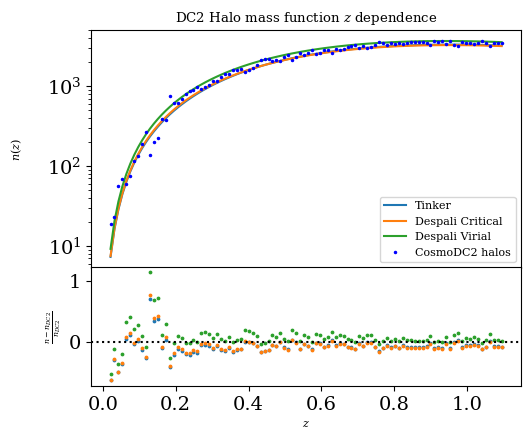

In [9]:
mulfs = [Nc.MultiplicityFuncTinker.new() , Nc.MultiplicityFuncDespali.new(), Nc.MultiplicityFuncDespali.new()]
mulf_label = ["Tinker", "Despali Critical" , "Despali Virial"]
nbins=100
z = np.linspace(zmin, zmax , nbins +1)
z_bin = [(z[j] +z[j+1])/2 for j in range(len(z)-1)]
counts_z, bins = np.histogram(data_dc2['redshift_true'], bins=z)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True,gridspec_kw={'height_ratios': [2, 1]},figsize=(5,4))
#fig.suptitle("DC2 halos as a function of z")
for i in range(len(mulfs)):
    diff = []
    mulf = mulfs[i]
    if i == 2:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL) 

    else:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
        mulf.set_Delta(200.0)
    
    hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
    hmf.prepare(cosmo)
    hmf.set_area(sky_area * (np.pi / 180) ** 2)
    hbias = Nc.HaloBiasDespali.new(hmf)
    cad = Nc.ClusterAbundance.new(hmf, hbias)
    cad.set_area(sky_area * (np.pi / 180) ** 2)
    
    
    cad.prepare(cosmo , cluster_z , cluster_m)
    print(cad.n(cosmo ,cluster_z , cluster_m))
    
    abundance = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [np.log(10**logMmin)] , [np.log(10**logMmax)], None, [z[j]] , [z[j+1]] , None)  for j in range(len(lnM)-1)]
    diff = [(abundance[j] - counts_z[j])/counts_z[j] for j in range(len(z)-1)]

    #PLOT
    
    
    ax1.plot(z_bin,abundance,'-', label=mulf_label[i]) #Best fit model
    #plt.axis([lnM_bin[0], lnM_bin[-1], 0.0,counts_lnM.max()])
    
    ax1.set_yscale("log")
    #plt.axis([lnM_bin[0], lnM_bin[-1], counts_lnM.min(),counts_lnM.max()])
    ax2.scatter(z_bin,diff, label=mulf_label[i],s=3)


ax1.plot(z_bin,counts_z,'.b',label='CosmoDC2 halos',ms=3) #Noisy data
ax1.set_ylabel(r"$n(z)$",labelpad=16)
ax1.set_title(r'DC2 Halo mass function $z$ dependence')
ax1.tick_params(axis='both', which='major', labelsize=14)
#ax1.grid()
ax2.axhline(y=0.0, color='black', linestyle='dotted')
ax1.legend(loc='best')
ax2.set_xlabel(r"$z$")
ax2.set_ylabel(r"$\frac{n - n_{DC2}}{n_{DC2}}$ ")
#ax2.grid()
plt.savefig("residuals_hmf_z.png")

extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('residual_lnM.png', bbox_inches=extent)
plt.tight_layout(pad=-0.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("residuals_hmf_z.jpg",bbox_inches='tight',dpi=300)
plt.show()